In [15]:
import numpy as np
from tqdm import tqdm
import os

io_path = '/dk/lcj_rag/pyserini-autofusion/experiments/runs'

depth=1000
#  alpha*bf + (1-alpha)*bm25
nq = -1
k=100

train_bf_trec_path = f'{io_path}/base_trec/run.dpr.wq-train.multi.bf.trec'
train_bm25_trec_path = f'{io_path}/base_trec/run.dpr.wq-train.bm25.trec'
cache_path = '/dk/lcj_rag/pyserini-autofusion/experiments/cache/'
fusion_tag = 'fusion'

train_embedding_path = '/dk/rag-dataset/queries/query-embedding-dpr_multi-wq-train-20240508-9323ec.feaa4458c033613812bb9b84ff015669/embedding.pkl'
filename = f'{io_path}/wq_train/run.dpr.wq-train.{fusion_tag}.all-alpha.k-{k}.res'



In [18]:
filename += '.3_classes'
print(filename)

/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_train/run.dpr.wq-train.fusion.all-alpha.k-100.res.3_classes


In [17]:
out_json_path = f'{io_path}/wq_train/run.dpr.wq-train.{fusion_tag}.alpha-?.k-{k}.json'

cmd2 = f'python -m pyserini.eval.evaluate_dpr_retrieval_all_alpha \
    --retrieval {out_json_path} \
    --topk 100'
res = os.system(cmd2 + f'1> {filename}')
print(filename)

# Num classes: [30, 3251, 497]

  0%|          | 0/21 [00:00<?, ?it/s]
0it [00:00, ?it/s]
3778it [00:00, 18831.29it/s]
  5%|▍         | 1/21 [00:01<00:22,  1.15s/it]
0it [00:00, ?it/s]
1592it [00:00, 15913.00it/s]
3778it [00:00, 16709.32it/s]
 10%|▉         | 2/21 [00:02<00:23,  1.22s/it]
0it [00:00, ?it/s]
1506it [00:00, 15047.74it/s]
3778it [00:00, 15056.63it/s]
 14%|█▍        | 3/21 [00:03<00:23,  1.30s/it]
0it [00:00, ?it/s]
1726it [00:00, 17253.52it/s]
3778it [00:00, 18025.84it/s]
 19%|█▉        | 4/21 [00:04<00:21,  1.25s/it]
0it [00:00, ?it/s]
1473it [00:00, 14725.49it/s]
3778it [00:00, 16797.12it/s]
 24%|██▍       | 5/21 [00:06<00:19,  1.24s/it]
0it [00:00, ?it/s]
1737it [00:00, 17366.62it/s]
3778it [00:00, 17989.78it/s]
 29%|██▊       | 6/21 [00:07<00:19,  1.27s/it]
0it [00:00, ?it/s]
1800it [00:00, 17995.00it/s]
3778it [00:00, 18706.62it/s]
 33%|███▎      | 7/21 [00:08<00:17,  1.23s/it]
0it [00:00, ?it/s]
1560it [00:00, 15597.26it/s]
3778it [00:00, 17479.56it/s]
 38%|███▊      | 8/21 [00:09<00:15,  1.22s/it

/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_train/run.dpr.wq-train.fusion.all-alpha.k-100.res


In [ ]:
import csv
import pickle

cutoff = 100

with open(filename, 'r') as f:
    print(f'filename: {filename}')
    reader = csv.reader(f, delimiter='\t')
    rows = list(reader)
    print(rows[:5])
    y = [float(alpha) for qid, alpha, num_hits in rows]
    qid_s = set([int(qid) for qid, alpha, num_hits in rows])

with open(train_bf_trec_path, 'r') as f:
    print(f'train_bf_trec_path: {train_bf_trec_path}')
    reader = csv.reader(f, delimiter=' ')
    rows = list(reader)
    print(rows[:5])
    curr = []
    bf_score_list = []
    for i, row in enumerate(rows):
        qid, _, docid, rank, score, _ = row
        qid = int(qid)
        if qid not in qid_s:
            continue
            
        rank = int(rank)
        score = float(score)
        if rank <= cutoff:
            curr.append(score)
            if rank == cutoff:
                bf_score_list.append(curr)
                curr = []
        else:
            continue

with open(train_bm25_trec_path, 'r') as f:
    print(f'train_bm25_trec_path: {train_bm25_trec_path}')
    reader = csv.reader(f, delimiter=' ')
    rows = list(reader)
    print(rows[:5])
    curr = []
    bm25_score_list = []
    for i, row in enumerate(rows):
        qid, _, docid, rank, score, _ = row
        qid = int(qid)
        if qid not in qid_s:
            continue
        
        rank = int(rank)
        score = float(score)
        if rank <= cutoff:
            curr.append(score)
            if rank == cutoff:
                bm25_score_list.append(curr)
                curr = []
        else:
            continue

with open(train_embedding_path, 'rb') as f:
    print(f'train_embedding_path: {train_embedding_path}')
    embeddings = pickle.load(f)
    embeddings = embeddings['embedding'].tolist()
    embeddings = [embeddings[i] for i in list(qid_s)]
    print(embeddings[:5])

In [14]:
nq = len(embeddings)
print(nq)

print(len(embeddings))
print(len(bf_score_list))
print(len(bm25_score_list))
print(len(y))

X = [list(embeddings[i]) + bf_score_list[i] + bm25_score_list[i] for i in range(nq)]
# X = [bf_score_list[i] + bm25_score_list[i] for i in range(nq)]
# print((X[0]))


Xy = [X[i] + [y[i]] for i in range(nq)]
print(len((Xy[0])), (Xy[0]))

with open(f'/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_train/wq_train_Xy-top{cutoff}.csv', 'w') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerows(Xy)
print(f'/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_train/wq_train_Xy-top{cutoff}.csv')

3778
3778
3778
3778
3778
969 [0.07069392, 0.09552774, 0.44034424, 0.08867934, 0.21568751, -0.1992523, 0.12765098, 0.23372807, -0.35129488, 0.015232541, 0.038528766, -0.08403179, -0.28401226, -0.24079978, 0.3546738, -0.15376163, -0.020253355, 0.41117635, -0.1464192, -0.14098606, 0.08126027, 0.25947368, 0.1566034, -0.19384328, 0.17899463, 0.3630663, -0.0799763, -0.14111751, -0.26087248, -0.11719218, 0.3290205, -0.021506034, 0.21493857, 0.20288095, 0.3501755, 0.016974164, -0.13110605, -0.31780195, -0.1590272, 0.015464416, 0.08474655, -0.014370729, -0.27593258, 0.13838847, -0.19889075, -0.012222774, -0.006841022, 0.31148574, -0.09865362, -0.2236041, 0.019229803, -0.30210897, -0.28323737, 0.040855125, 0.05120181, -0.07364914, 0.17662147, -0.15638874, -0.21706328, -0.26652077, 0.32251808, -0.10344728, -0.03462376, -0.45041573, 0.21330702, 0.07140127, 0.17146643, 0.12321412, -0.11821953, 0.1324617, 0.23429713, -0.108892836, -0.6901578, 0.05180281, 0.52458346, 0.26768392, -0.19558486, 0.236949

In [12]:
print(np.mean(y))


0.5178057173107464


In [ ]:
import csv
import numpy as np
import pickle

cutoff = 100
pkl_file = f'/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_train/wq_train_Xy-top{cutoff}.pkl'
csv_file = f'/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_train/wq_train_Xy-top{cutoff}.csv'
# with open(csv_file, 'r') as f:
#     reader = csv.reader(f)
#     data = list(reader)
#     Xy_np = np.array(data).astype(float)
#     X_np = Xy_np[:, :-1]
#     y_np = Xy_np[:, -1]

# with open(pkl_file, 'wb') as f:
#     pickle.dump(Xy_np, f)

# # Load data using pickle
with open(pkl_file, 'rb') as f:
    Xy_np = pickle.load(f)
    X_np = Xy_np[:, :-1]
    y_np = Xy_np[:, -1]

# with open(csv_file, 'w') as f:
#     writer = csv.writer(f, delimiter=',')
#     writer.writerows(Xy_np)

# X_np = X_np[:, :768]

# X_np = np.hstack((X_np[:, :768], X_np[:, 768:868], X_np[:, 968:1068]))

# X_np = X_np[:, 768:]
# X1_np = X_np[:, :cutoff]
# X2_np = X_np[:, cutoff:]

# selected_columns = [0, 1, 3, 7, 15, 31, 63]

# X1_np = X1_np[:, selected_columns]
# X2_np = X2_np[:, selected_columns]
# X_np = np.hstack((X1_np, X2_np))


# print(f'X1_np: {X1_np.shape}')
# print(f'X2_np: {X1_np.shape}')

# for row in range(50):
#     print(row, X_np[row, :8], X_np[row, 8:], y_np[row])

print(X_np.shape)
print(y_np.shape)
print(np.mean(y_np))


# # from sklearn.decomposition import PCA
# # with open(pkl_file, 'rb') as f:
# #     X_np, y_np = pickle.load(f)

# # # 输出原始数据的形状
# # print("原始数据形状：", X_np.shape)
# # print("标签数据形状：", y_np.shape)

# # 提取要降维的数据
# data_to_reduce = X_np[:, :768]

# # 设置PCA降维的目标维数，这里设为128维
# k = 384

# # 创建PCA对象并进行降维
# from sklearn.decomposition import PCA
# pca = PCA(n_components=k)
# reduced_data = pca.fit_transform(data_to_reduce)

# # 将降维后的数据与后面的数据合并
# X_np = np.hstack((reduced_data, X_np[:, 768:]))

# # 输出降维后的数据形状
# print("降维后的数据形状：", X_np.shape)

y_np = np.abs(y_np - 0.5) >= 0.25
print(np.sum(y_np))
print(np.mean(y_np))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42)

# valid_indices = np.abs(y_train - 0.5) > 0.05
# # print(valid_indices)
# X_train = X_train[valid_indices]
# y_train = y_train[valid_indices]

indices = np.where(np.abs(y_train - 0.5) >= 0.25)[0]
print(indices + 1)
print(X_np[indices])

# print(np.abs(y_train - 0.5)[:5])
# w_train = np.power(np.e, np.abs(y_train - 0.5)*100)
# distance = np.abs(y_train - 0.5) * 100
# distance = np.power(distance, 10.0)
# distance -= np.max(distance)

# distance[distance == 0.0] -= 10
# w_train = distance

# w_train = np.power(np.e, distance)
w_train = np.ones(y_train.shape)
# for i in range(500):
#     print(round(distance[i], 2), y_train[i], round(w_train[i], 2))
# X_train, y_train = X_np, y_np
print(X_train.shape)
print(w_train.shape)

# # 进行数据集划分
# X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_np, test_size=0.05, random_state=42)

# # 输出划分后数据集的形状
# print("训练集形状：", X_train.shape)
# print("测试集形状：", X_test.shape)
# print("训练标签形状：", y_train.shape)
# print("测试标签形状：", y_test.shape)

/tmp/ipykernel_991283/1340908844.py:3: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, bin_edges = np.histogram(y_train, bins=bin_edges)


3022
[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]


/tmp/ipykernel_991283/1340908844.py:53: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist_sampled, _ = np.histogram(y_train_sampled, bins=bin_edges)


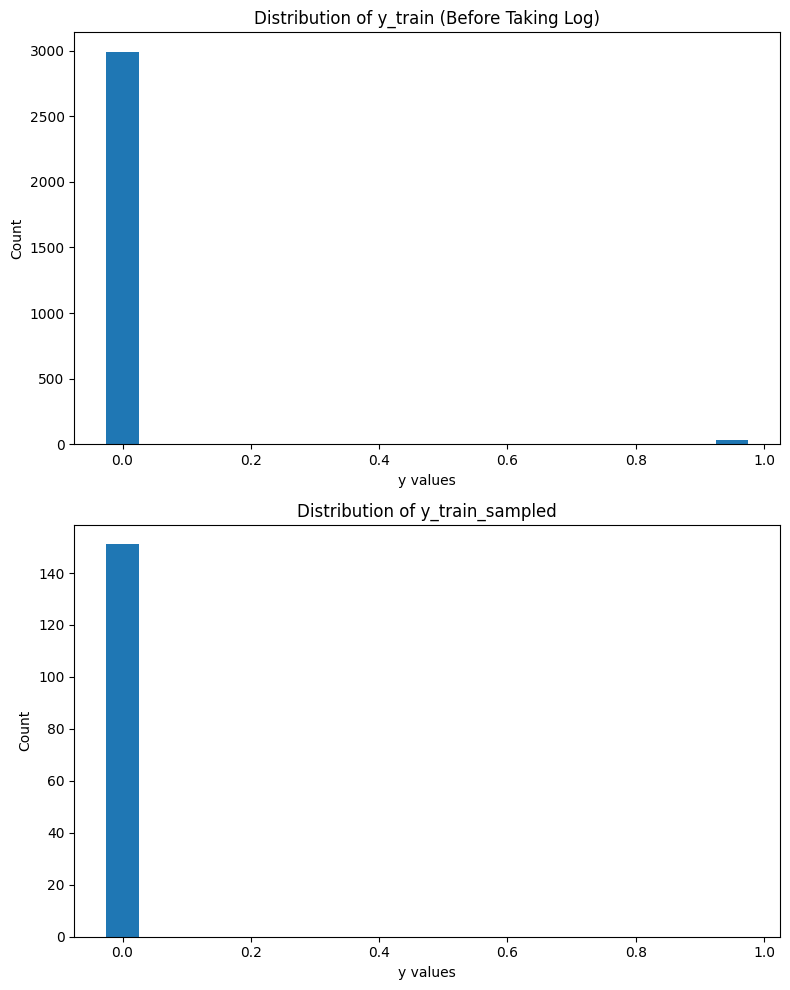

151


In [2]:
bin_edges = np.linspace(0, 1, num=21)

hist, bin_edges = np.histogram(y_train, bins=bin_edges)
print(len(y_train))

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
# ax1.bar(bin_edges[:-1], hist, width=0.05)
# ax1.set_title('Distribution of y_train (Before Taking Log)')
# ax1.set_xlabel('y values')
# ax1.set_ylabel('Count')

hist_log = np.log(hist + 1)
# hist_log = np.log(hist_log + 1)
# hist_log = np.log(hist_log + 1)
hist_log = np.ones(hist_log.shape)
hist_log_norm = hist_log / np.sum(hist_log)
print(hist_log_norm)
# # [0.         0.0312592  0.04000554 0.03927602 0.04294942 0.04840352
# #  0.05252923 0.05689486 0.06303176 0.0633484  0.07275313 0.05918789
# #  0.06092189 0.05710447 0.05275093 0.05346306 0.05456898 0.05097607
# #  0.05342812 0.0471475 ]
# ax2.bar(bin_edges[:-1], hist_log, width=0.05)
# ax2.set_title('Distribution of y_train (After Taking Log)')
# ax2.set_xlabel('y values')
# ax2.set_ylabel('Log Count')

# # plt.tight_layout()
# # plt.show()


sample_indices = []
for i in range(len(bin_edges[:-1])):
    indices = np.where(np.digitize(y_train, bin_edges) == i)[0]
    num_samples = int(hist_log_norm[i] * len(X_train))
    if len(indices) > 0:
        samples = np.random.choice(indices, size=num_samples, replace=(num_samples > len(indices)))
        sample_indices.extend(samples)

sample_indices = np.array(sample_indices)

X_train_sampled = X_train[sample_indices]
y_train_sampled = y_train[sample_indices]

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

ax1.bar(bin_edges[:-1], hist, width=0.05)
ax1.set_title('Distribution of y_train (Before Taking Log)')
ax1.set_xlabel('y values')
ax1.set_ylabel('Count')

hist_sampled, _ = np.histogram(y_train_sampled, bins=bin_edges)
ax2.bar(bin_edges[:-1], hist_sampled, width=0.05)
ax2.set_title('Distribution of y_train_sampled')
ax2.set_xlabel('y values')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()
X_train, y_train = X_train_sampled, y_train_sampled
print(len(y_train_sampled))

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

import numpy as np

train_data = lgb.Dataset(X_train, label=y_train, weight=w_train)

params = {
    'learning_rate': 0.03, 
    'max_depth': -1, 
    'metric': {'binary_logloss', 'auc'},
    "boosting": "gbdt",
    'n_estimators': 500,
    "nthread": 24, 
    'num_leaves': 71, 
    'objective': 'binary'
}

model = lgb.train(params, train_data, num_boost_round=750)


# # Define the parameter grid for grid search
# param_grid = {
#     'objective': ['regression'],
#     'metric': ['l1'],
#     'num_leaves': [31, 51, 71],
#     'max_depth': [10, 15, 20],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [100, 200, 300]
# }

# # Define the LightGBM model
# model = lgb.LGBMRegressor()

# # Perform grid search
# grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
# grid_search.fit(X_train, y_train)

# # Get the best parameters and model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# # Make predictions on the test set using the best model
# y_pred = best_model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(bool)

# 假分类准确率
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm)

# 分类报告
report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

# 打印预测和实际值
for i in range(len(y_test)):
    print(f'{i}, {y_pred[i]}, {y_test[i]}')


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import numpy as np

# 创建LightGBM数据集
train_data = lgb.Dataset(X_train, label=y_train)

# 设置回归参数
params = {
    'learning_rate': 0.01, 
    'max_depth': 17, 
    'metric': 'rmse', 
    'n_estimators': 500, 
    'num_leaves': 51, 
    'objective': 'regression'
}

model = lgb.train(params, train_data, num_boost_round=500)

y_pred = model.predict(X_test)

# # Define the parameter grid for grid search
# param_grid = {
#     'objective': ['regression'],
#     'metric': ['l1'],
#     'num_leaves': [31, 51, 71],
#     'max_depth': [10, 15, 20],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [100, 200, 300]
# }

# # Define the LightGBM model
# model = lgb.LGBMRegressor()

# # Perform grid search
# grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
# grid_search.fit(X_train, y_train)

# # Get the best parameters and model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# # Make predictions on the test set using the best model
# y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('RMSE:', rmse)

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print('MAE:', mae)

from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print('R²:', r2)

for i in range(100):
    print(round(y_pred[i], 2), round(y_test[i], 2))

print(np.mean(y_pred))
print(np.mean(y_test))

In [39]:
print('Best Parameters:', grid_search.best_params_)

NameError: name 'grid_search' is not defined

# Get train data for bert

In [1]:
import numpy as np
from tqdm import tqdm
import os

io_path = '/dk/lcj_rag/pyserini-autofusion/experiments/runs'

depth=1000
#  alpha*bf + (1-alpha)*bm25
nq = -1
k=100

train_bf_trec_path = f'{io_path}/base_trec/run.dpr.wq-train.multi.bf.trec'
train_bm25_trec_path = f'{io_path}/base_trec/run.dpr.wq-train.bm25.trec'
cache_path = '/dk/lcj_rag/pyserini-autofusion/experiments/cache/'
fusion_tag = 'fusion'

train_embedding_path = '/dk/rag-dataset/queries/query-embedding-dpr_multi-wq-train-20240508-9323ec.feaa4458c033613812bb9b84ff015669/embedding.pkl'
filename = f'{io_path}/wq_train/run.dpr.wq-train.{fusion_tag}.all-alpha.k-{k}.res'



In [ ]:
import csv
import numpy as np
import pickle
import json

cutoff = 100
pkl_file = f'/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_train/wq_train_Xy-top{cutoff}.pkl'
csv_file = f'/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_train/wq_train_Xy-top{cutoff}.csv'
qa_path = '/root/.cache/anserini/topics-and-qrels/'
qa_file = f'{qa_path}topics.dpr.wq.train.txt'

with open(qa_file, 'r', encoding='utf-8') as file:
    data = [json.loads(line) for line in file]

questions = [item['question'] for item in data]

questions_np = np.array(questions)
# for question in questions[:5]:
#     # what kind of money to take to bahamas?
#     print(question)

questions_np = questions_np.reshape(-1, 1)
# for question in questions_np[:5]:
#     # ['what kind of money to take to bahamas?']
#     print(question)

# # Load data using pickle
with open(pkl_file, 'rb') as f:
    Xy_np = pickle.load(f)
    X_np = Xy_np[:, :-1]
    # y_np = Xy_np[:, -1].reshape(-1, 1)

filename = '/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_train/run.dpr.wq-train.fusion.all-alpha.k-100.res'
filename += '.3_classes'
with open(filename, 'r') as f:
    print(f'filename: {filename}')
    reader = csv.reader(f, delimiter='\t')
    rows = list(reader)
    print(f'filename[:5]: {rows[:5]}')
    y_np = np.array([float(alpha) for qid, alpha, num_hits in rows]).reshape(-1, 1).astype(int)

X_np = X_np[:, 768:]
print(f'questions_np.shape: {questions_np.shape}')
print(f'X_np.shape: {X_np.shape}')

for q in range(X_np.shape[0]):
    print(np.hstack((X_np[q, :5], X_np[q, 100:100 + 5])), y_np[q])
    # print(X_np[q, 99] / X_np[q, 0], X_np[q, 199] / X_np[q, 100], y_np[q])

X_np = np.hstack((questions_np, X_np))


print(X_np.shape)
print(y_np.shape)
print(np.mean(y_np))

# y_np = (np.abs(y_np - 0.5) >= 0.25).astype(int)
print(y_np[:200])
# print(np.sum(y_np))
print(np.mean(y_np))

Xy_np = np.concatenate((X_np, y_np), axis=1)
bert_train = f'/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_train/wq_bert_classification_train_Xy-top{cutoff}.3_classes.pkl'
with open(bert_train, 'wb') as f:
    pickle.dump(Xy_np, f)


# Get test data for BERT

In [7]:
import csv
import numpy as np
import pickle
import json

cutoff = 200
qa_path = '/root/.cache/anserini/topics-and-qrels/'
qa_file = f'{qa_path}topics.dpr.wq.test.txt'
print(qa_file)

with open(qa_file, 'r', encoding='utf-8') as file:
    data = [json.loads(line) for line in file]

questions = [item['question'] for item in data]
print(questions[0])
# questions = [question for question in questions]

questions_np = np.array(questions)
for question in questions[:5]:
    # what kind of money to take to bahamas?
    print(question)

questions_np = questions_np.reshape(-1, 1)
for question in questions_np[:5]:
    # ['what kind of money to take to bahamas?']
    print(question)

pkl_file = '/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_train/wq_test_X.pkl'
csv_file = '/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_train/wq_test_X.csv'
with open(csv_file, 'r') as f:
    reader = csv.reader(f)
    data = list(reader)
    X_np = np.array(data).astype(float)

with open(pkl_file, 'wb') as f:
    pickle.dump(X_np, f)

# Load data using pickle
with open(pkl_file, 'rb') as f:
    X_np = pickle.load(f)


X_np = X_np[:, 768:]
print(f'questions_np.shape: {questions_np.shape}')
print(f'X_np.shape: {X_np.shape}')
X_np = np.hstack((questions_np, X_np))


print(X_np.shape)

bert_test = f'/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_test/wq_bert_test_Xy-top{cutoff}.pkl'
with open(bert_test, 'wb') as f:
    pickle.dump(X_np, f)



/root/.cache/anserini/topics-and-qrels/topics.dpr.wq.test.txt
what does jamaican people speak?
what does jamaican people speak?
what did james k polk do before he was president?
what is the oregon ducks 2012 football schedule?
who plays ken barlow in coronation street?
what happened after mr. sugihara died?
['what does jamaican people speak?']
['what did james k polk do before he was president?']
['what is the oregon ducks 2012 football schedule?']
['who plays ken barlow in coronation street?']
['what happened after mr. sugihara died?']
questions_np.shape: (2032, 1)
X_np.shape: (2032, 200)
(2032, 201)


# Test BERT

In [1]:
import numpy as np
from tqdm import tqdm
import os

io_path = '/dk/lcj_rag/pyserini-autofusion/experiments/runs'

depth=1000
#  alpha*bf + (1-alpha)*bm25
nq = -1
k=100

test_bf_trec_path = f'{io_path}/base_trec/run.dpr.wq-test.multi.bf.trec'
test_bm25_trec_path = f'{io_path}/base_trec/run.dpr.wq-test.bm25.trec'
cache_path = '/dk/lcj_rag/pyserini-autofusion/experiments/cache/'
fusion_tag = 'dpr.bm25.fusion'

filename = f'{io_path}/wq_test/run.dpr.wq-test.{fusion_tag}.all-alpha.nq-{nq}.k-{k}.res'
test_embedding_path = '/dk/rag-dataset/queries/query-embedding-dpr_multi-wq-test-20210419-9323ec.19aa721632d05afe031cc2da83a9a5a5/embedding.pkl'



In [ ]:
alphafile = '/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_test/wq_bert_test_predictions.csv'
test_out_trec_path = f'{io_path}/wq_test/run.dpr.wq-test.{fusion_tag}.alpha-custom-bert.k-{k}.trec'
test_out_json_path = f'{io_path}/wq_test/run.dpr.wq-test.{fusion_tag}.alpha-custom-bert.k-{k}.json'

cmd0 = f'python -m pyserini.autofusion \
        --runs {test_bf_trec_path} {test_bm25_trec_path}    \
        --runtag {fusion_tag}-custom \
        --method halftops  \
        --alphafile {alphafile} \
        --depth {depth}  \
        --nq -1  \
        --k {k} \
        --output {test_out_trec_path}'
os.system(cmd0)

In [6]:

cache_path = '/dk/lcj_rag/pyserini-autofusion/experiments/cache/'
cmd1 = f'python -m pyserini.eval.convert_trec_run_to_dpr_retrieval_run_on_cache \
  --index wikipedia-dpr-100w \
  --topics dpr-wq-test \
  --gt {cache_path}wq_test_bf_qid_gt_set.pkl {cache_path}wq_test_bm25_qid_gt_set.pkl \
  --input {test_out_trec_path} \
  --output {test_out_json_path}'
os.system(cmd1)

resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


Jun 21, 2024 8:37:14 AM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
100%|██████████| 203200/203200 [08:27<00:00, 400.78it/s] 


0

In [7]:
# test_out_json_path = f'{io_path}/wq_test/run.dpr.wq-test.{fusion_tag}.alpha-gt.k-{k}.json'
nq = -1
test_out_json_path = f'{io_path}/wq_test/run.dpr.wq-test.{fusion_tag}.alpha-custom-bert.k-{k}.json'
print(test_out_json_path)
cmd2 = f'python -m pyserini.eval.evaluate_dpr_retrieval \
  --retrieval {test_out_json_path} \
  --topk 100'
os.system(cmd2)


/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_test/run.dpr.wq-test.dpr.bm25.fusion.alpha-custom-bert.k-100.json


100%|██████████| 2032/2032 [00:00<00:00, 17759.33it/s]


qid: 4	Top100	has_answer: 0
qid: 5	Top100	has_answer: 0
qid: 21	Top100	has_answer: 0
qid: 25	Top100	has_answer: 0
qid: 46	Top100	has_answer: 0
qid: 51	Top100	has_answer: 0
qid: 59	Top100	has_answer: 0
qid: 63	Top100	has_answer: 0
qid: 113	Top100	has_answer: 0
qid: 131	Top100	has_answer: 0
qid: 136	Top100	has_answer: 0
qid: 141	Top100	has_answer: 0
qid: 145	Top100	has_answer: 0
qid: 152	Top100	has_answer: 0
qid: 155	Top100	has_answer: 0
qid: 163	Top100	has_answer: 0
qid: 176	Top100	has_answer: 0
qid: 178	Top100	has_answer: 0
qid: 183	Top100	has_answer: 0
qid: 192	Top100	has_answer: 0
qid: 194	Top100	has_answer: 0
qid: 215	Top100	has_answer: 0
qid: 223	Top100	has_answer: 0
qid: 230	Top100	has_answer: 0
qid: 236	Top100	has_answer: 0
qid: 238	Top100	has_answer: 0
qid: 240	Top100	has_answer: 0
qid: 242	Top100	has_answer: 0
qid: 245	Top100	has_answer: 0
qid: 251	Top100	has_answer: 0
qid: 257	Top100	has_answer: 0
qid: 260	Top100	has_answer: 0
qid: 268	Top100	has_answer: 0
qid: 272	Top100	has_

0

## Get test ground truth


In [10]:
import numpy as np
from tqdm import tqdm
import os

io_path = '/dk/lcj_rag/pyserini-autofusion/experiments/runs'

depth=1000
#  alpha*bf + (1-alpha)*bm25
nq = -1
k=100

test_bf_trec_path = f'{io_path}/base_trec/run.dpr.wq-test.multi.bf.trec'
test_bm25_trec_path = f'{io_path}/base_trec/run.dpr.wq-test.bm25.trec'
cache_path = '/dk/lcj_rag/pyserini-autofusion/experiments/cache/'
fusion_tag = 'dpr.bm25.fusion.gt'

filename = f'{io_path}/wq_test/run.dpr.wq-test.{fusion_tag}.all-alpha.nq-{nq}.k-{k}.res'
test_embedding_path = '/dk/rag-dataset/queries/query-embedding-dpr_multi-wq-test-20210419-9323ec.19aa721632d05afe031cc2da83a9a5a5/embedding.pkl'



In [34]:
nq = -1
for alpha in tqdm(np.arange(0, 1.05, 0.05)):
    alpha = round(alpha, 2)
    alphafile = f'/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_test/alpha-{alpha}.csv'
    test_out_trec_path = f'{io_path}/wq_test/run.dpr.wq-test.{fusion_tag}.alpha-{alpha}.nq-{nq}.k-{k}.trec'
    test_out_json_path = f'{io_path}/wq_test/run.dpr.wq-test.{fusion_tag}.alpha-{alpha}.nq-{nq}.k-{k}.json'
    cmd0 = f'python -m pyserini.autofusion \
            --runs {test_bf_trec_path} {test_bm25_trec_path}    \
            --runtag {fusion_tag}-custom \
            --method custom  \
            --alphafile {alphafile} \
            --depth {depth}  \
            --nq {nq}  \
            --k {k} \
            --output {test_out_trec_path}'
    # print(cmd0)
    os.system(cmd0)

    cmd1 = f'python -m pyserini.eval.convert_trec_run_to_dpr_retrieval_run \
        --index wikipedia-dpr-100w \
        --topics dpr-wq-test \
        --input {test_out_trec_path} \
        --output {test_out_json_path}'
    os.system(cmd1)

  0%|          | 0/21 [00:00<?, ?it/s]

num_queries: 2032000


In [67]:
filename = f'{io_path}/wq_test/run.dpr.wq-test.{fusion_tag}.all-alpha.nq-{nq}.k-{k}.res.test'
test_out_json_path = f'{io_path}/wq_test/run.dpr.wq-test.{fusion_tag}.alpha-?.nq-{nq}.k-{k}.json'

cmd2 = f'python -m pyserini.eval.evaluate_dpr_retrieval_all_alpha \
    --retrieval {test_out_json_path} \
    --topk 100  \
    --traindata False'
res = os.system(cmd2 + f'1> {filename}')
print(filename)

  0%|          | 0/21 [00:00<?, ?it/s]
0it [00:00, ?it/s]
2032it [00:00, 19426.31it/s]
  5%|▍         | 1/21 [00:00<00:13,  1.47it/s]
0it [00:00, ?it/s]
2032it [00:00, 19289.26it/s]
 10%|▉         | 2/21 [00:01<00:12,  1.56it/s]
0it [00:00, ?it/s]
2032it [00:00, 19250.10it/s]
 14%|█▍        | 3/21 [00:01<00:11,  1.60it/s]
0it [00:00, ?it/s]
2032it [00:00, 19243.01it/s]
 19%|█▉        | 4/21 [00:02<00:10,  1.62it/s]
0it [00:00, ?it/s]
2032it [00:00, 19144.20it/s]
 24%|██▍       | 5/21 [00:03<00:09,  1.63it/s]
0it [00:00, ?it/s]
2032it [00:00, 18729.80it/s]
 29%|██▊       | 6/21 [00:03<00:09,  1.56it/s]
0it [00:00, ?it/s]
2032it [00:00, 19113.25it/s]
 33%|███▎      | 7/21 [00:04<00:08,  1.57it/s]
0it [00:00, ?it/s]
2032it [00:00, 19118.43it/s]
 38%|███▊      | 8/21 [00:05<00:08,  1.59it/s]
0it [00:00, ?it/s]
2032it [00:00, 19061.99it/s]
 43%|████▎     | 9/21 [00:05<00:07,  1.61it/s]
0it [00:00, ?it/s]
2032it [00:00, 19283.94it/s]
 48%|████▊     | 10/21 [00:06<00:06,  1.62it/s]
0it [00:00

/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_test/run.dpr.wq-test.dpr.bm25.fusion.gt.all-alpha.nq--1.k-100.res.test


In [12]:
print(test_out_json_path)

/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_test/run.dpr.wq-test.dpr.bm25.fusion.gt.alpha-?.nq--1.k-100.json


In [41]:
import csv
with open(filename, 'r') as f:
    print(f'filename: {filename}')
    reader = csv.reader(f, delimiter='\t')
    rows = list(reader)
    print(rows[:5])
    gt_y = [float(alpha) for qid, alpha, num_hits in rows]
    gt_y = np.array(gt_y)

# gt_y = np.abs(gt_y - 0.5) > 0.25
# print(np.sum(gt_y))
# gt_y = np.array([1.0 if y else 0.5 for y in gt_y])
# print(gt_y)
print(np.mean(gt_y))

nq = -1
gt_csv = f'{io_path}/wq_test/run.dpr.wq-test.{fusion_tag}.alpha-gt.nq-{nq}.k-{k}.csv'
with open(gt_csv, 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    for alpha in gt_y:
        writer.writerow([alpha])
print(gt_csv)

filename: /dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_test/run.dpr.wq-test.dpr.bm25.fusion.gt.all-alpha.nq--1.k-100.res
[['0', '0.49', '92'], ['1', '0.54', '65'], ['2', '0.45', '731'], ['3', '0.52', '86'], ['4', '0.5', '0']]
0.5015600393700788
/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_test/run.dpr.wq-test.dpr.bm25.fusion.gt.alpha-gt.nq--1.k-100.csv


In [23]:

nq = -1
gt_csv = f'{io_path}/wq_test/run.dpr.wq-test.{fusion_tag}.alpha-gt.nq-{nq}.k-{k}.csv'
alphafile = gt_csv
test_out_trec_path = f'{io_path}/wq_test/run.dpr.wq-test.{fusion_tag}.alpha-gt.nq-{nq}.k-{k}.trec'
test_out_json_path = f'{io_path}/wq_test/run.dpr.wq-test.{fusion_tag}.alpha-gt.nq-{nq}.k-{k}.json'
cmd0 = f'python -m pyserini.autofusion \
        --runs {test_bf_trec_path} {test_bm25_trec_path}    \
        --runtag {fusion_tag}-custom \
        --method custom  \
        --alphafile {alphafile} \
        --depth {depth}  \
        --nq {nq}  \
        --k {k} \
        --output {test_out_trec_path}'
os.system(cmd0)

Interpolation custom
num_queries: 2032000
60 alpha: {0.49, 0.54, 0.45, 0.5, 0.52, 0.42, 0.48, 0.46, 0.47, 0.44, 0.59, 0.83, 0.84, 0.0, 0.34, 0.51, 0.43, 0.6, 0.35, 0.68, 0.05, 0.77, 0.94, 0.69, 0.27, 0.66, 0.61, 0.36, 0.04, 0.53, 0.7, 0.78, 0.28, 0.62, 0.37, 0.09, 0.79, 0.63, 0.38, 0.3, 0.55, 0.02, 0.64, 0.39, 0.89, 0.31, 0.06, 0.08, 0.56, 0.73, 0.81, 0.57, 0.4, 0.9, 0.65, 0.07, 0.32, 0.41, 0.58, 0.33}


0

In [50]:
test_out_json_path = f'{io_path}/wq_test/run.dpr.wq-test.{fusion_tag}.alpha-gt-oncache.nq-{nq}.k-{k}.json'
print(test_out_json_path)

/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_test/run.dpr.wq-test.dpr.bm25.fusion.gt.alpha-gt-oncache.nq--1.k-100.json


In [20]:
cache_path = '/dk/lcj_rag/pyserini-autofusion/experiments/cache/'
cmd1 = f'python -m pyserini.eval.convert_trec_run_to_dpr_retrieval_run_on_cache \
  --index wikipedia-dpr-100w \
  --topics dpr-wq-test \
  --gt {cache_path}wq_test_bf_qid_gt_set.pkl {cache_path}wq_test_bm25_qid_gt_set.pkl \
  --input {test_out_trec_path} \
  --output {test_out_json_path}'
os.system(cmd1)

resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


Jun 21, 2024 1:51:46 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
100%|██████████| 203200/203200 [00:28<00:00, 7168.58it/s]


0

In [22]:
nq = -1
test_out_json_path = f'{io_path}/wq_test/run.dpr.wq-test.{fusion_tag}.alpha-gt.nq-{nq}.k-{k}.json'
test_out_json_path = f'{io_path}/wq_test/run.dpr.wq-test.{fusion_tag}.alpha-gt-oncache.nq-{nq}.k-{k}.json'
print(test_out_json_path)
cmd2 = f'python -m pyserini.eval.evaluate_dpr_retrieval \
  --retrieval {test_out_json_path} \
  --topk 100'
os.system(cmd2)
# bm25 + bf


/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_test/run.dpr.wq-test.dpr.bm25.fusion.gt.alpha-gt-oncache.nq--1.k-100.json


100%|██████████| 2032/2032 [00:00<00:00, 19123.58it/s]


qid: 4	Top100	has_answer: 0
qid: 5	Top100	has_answer: 0
qid: 21	Top100	has_answer: 0
qid: 25	Top100	has_answer: 0
qid: 46	Top100	has_answer: 0
qid: 51	Top100	has_answer: 0
qid: 59	Top100	has_answer: 0
qid: 63	Top100	has_answer: 0
qid: 113	Top100	has_answer: 0
qid: 131	Top100	has_answer: 0
qid: 136	Top100	has_answer: 0
qid: 141	Top100	has_answer: 0
qid: 152	Top100	has_answer: 0
qid: 155	Top100	has_answer: 0
qid: 163	Top100	has_answer: 0
qid: 176	Top100	has_answer: 0
qid: 178	Top100	has_answer: 0
qid: 183	Top100	has_answer: 0
qid: 192	Top100	has_answer: 0
qid: 194	Top100	has_answer: 0
qid: 215	Top100	has_answer: 0
qid: 223	Top100	has_answer: 0
qid: 230	Top100	has_answer: 0
qid: 236	Top100	has_answer: 0
qid: 238	Top100	has_answer: 0
qid: 240	Top100	has_answer: 0
qid: 242	Top100	has_answer: 0
qid: 245	Top100	has_answer: 0
qid: 251	Top100	has_answer: 0
qid: 257	Top100	has_answer: 0
qid: 268	Top100	has_answer: 0
qid: 272	Top100	has_answer: 0
qid: 274	Top100	has_answer: 0
qid: 288	Top100	has_

0

## Get test features

In [1]:
import numpy as np
from tqdm import tqdm
import os

io_path = '/dk/lcj_rag/pyserini-autofusion/experiments/runs'

depth=1000
#  alpha*bf + (1-alpha)*bm25
nq = -1
k=100

test_bf_trec_path = f'{io_path}/base_trec/run.dpr.wq-test.multi.bf.trec'
test_bm25_trec_path = f'{io_path}/base_trec/run.dpr.wq-test.bm25.trec'
cache_path = '/dk/lcj_rag/pyserini-autofusion/experiments/cache/'
fusion_tag = 'fusion'

filename = f'{io_path}/nq_train/run.dpr.wq-test.{fusion_tag}.all-alpha.k-{k}.res'
test_embedding_path = '/dk/rag-dataset/queries/query-embedding-dpr_multi-wq-test-20210419-9323ec.19aa721632d05afe031cc2da83a9a5a5/embedding.pkl'



In [ ]:
import csv
import pickle

with open(test_bf_trec_path, 'r') as f:
    print(f'test_bf_trec_path: {test_bf_trec_path}')
    reader = csv.reader(f, delimiter=' ')
    rows = list(reader)
    print(rows[:5])
    curr = []
    bf_score_list = []
    for i, row in enumerate(rows):
        qid, _, docid, rank, score, _ = row
        qid = int(qid)
        rank = int(rank)
        score = float(score)
        if rank <= 100:
            curr.append(score)
            if rank == 100:
                bf_score_list.append(curr)
                curr = []
        else:
            continue

with open(test_bm25_trec_path, 'r') as f:
    print(f'test_bm25_trec_path: {test_bm25_trec_path}')
    reader = csv.reader(f, delimiter=' ')
    rows = list(reader)
    print(rows[:5])
    curr = []
    bm25_score_list = []
    for i, row in enumerate(rows):
        qid, _, docid, rank, score, _ = row
        qid = int(qid)        
        rank = int(rank)
        score = float(score)
        if rank <= 100:
            curr.append(score)
            if rank == 100:
                bm25_score_list.append(curr)
                curr = []
        else:
            continue

with open(test_embedding_path, 'rb') as f:
    print(f'test_embedding_path: {test_embedding_path}')
    embeddings = pickle.load(f)
    embeddings = embeddings['embedding'].tolist()
    print(embeddings[:5])

In [45]:
nq = len(embeddings)
print(nq)

print(len(embeddings), len(embeddings[0]))
print(len(bf_score_list), len(bf_score_list[0]))
print(len(bm25_score_list), len(bm25_score_list[0]))

X = [list(embeddings[i]) + bf_score_list[i] + bm25_score_list[i] for i in range(nq)]
# X = [bf_score_list[i] + bm25_score_list[i] for i in range(nq)]


with open('/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_train/wq_test_X.csv', 'w') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerows(X)

2032
2032 768
2032 100
2032 100


In [36]:
import csv
import numpy as np
import pickle

pkl_file = '/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_train/wq_test_X.pkl'
csv_file = '/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_train/wq_test_X.csv'
with open(csv_file, 'r') as f:
    reader = csv.reader(f)
    data = list(reader)
    X_np = np.array(data).astype(float)

# with open(pkl_file, 'wb') as f:
#     pickle.dump(X_np, f)

# Load data using pickle
# with open(pkl_file, 'rb') as f:
#     X_np = pickle.load(f)

# X_np = X_np[:, 768:]
print(X_np.shape)

X_test = X_np

(2032, 968)


In [37]:
y_pred = model.predict(X_test)
print(y_pred)
print(f'average of y_pred: {np.mean(y_pred)}')

alphafile = '/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_train/wq_test_y_pred.csv'
test_out_trec_path = f'{io_path}/wq_train/run.dpr.wq-test.{fusion_tag}.alpha-custom.k-{k}.trec'
test_out_json_path = f'{io_path}/wq_train/run.dpr.wq-test.{fusion_tag}.alpha-custom.k-{k}.json'


with open(alphafile, 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(y_pred)

[0.51482171 0.50112217 0.52405172 ... 0.63388112 0.68954788 0.575927  ]
average of y_pred: 0.6202570724764372


In [2]:

# alpha = 0.25
# alphafile = f'/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_train/alpha-{alpha}.csv'
# test_out_trec_path = f'{io_path}/wq_train/run.dpr.wq-test.{fusion_tag}.alpha-{alpha}.k-{k}.trec'
# test_out_json_path = f'{io_path}/wq_train/run.dpr.wq-test.{fusion_tag}.alpha-{alpha}.k-{k}.json'
# alphafile = '/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_train/wq_test_y_pred.csv'
# test_out_trec_path = f'{io_path}/wq_train/run.dpr.wq-test.{fusion_tag}.alpha-custom.k-{k}.trec'
# test_out_json_path = f'{io_path}/wq_train/run.dpr.wq-test.{fusion_tag}.alpha-custom.k-{k}.json'
# cmd0 = f'python -m pyserini.autofusion \
#         --runs {test_bf_trec_path} {test_bm25_trec_path}    \
#         --runtag {fusion_tag}-custom \
#         --method custom  \
#         --alphafile {alphafile} \
#         --depth {depth}  \
#         --nq -1  \
#         --k {k} \
#         --output {test_out_trec_path}'
# os.system(cmd0)

test_out_trec_path = f'{io_path}/wq_test/run.dpr.wq-test.{fusion_tag}.rrf.k-{k}.trec'
test_out_json_path = f'{io_path}/wq_test/run.dpr.wq-test.{fusion_tag}.rrf.k-{k}.json'
cmd0 = f'python -m pyserini.autofusion \
        --runs {test_bf_trec_path} {test_bm25_trec_path}    \
        --runtag {fusion_tag}-rrf \
        --method rrf  \
        --depth {depth}  \
        --nq -1  \
        --k {k} \
        --output {test_out_trec_path}'
os.system(cmd0)

0

In [15]:
print(test_out_trec_path)
print(test_out_json_path)

/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_test/run.dpr.wq-test.fusion.rrf.k-100.trec
/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_test/run.dpr.wq-test.fusion.rrf.k-100.json


In [3]:
cmd1 = f'python -m pyserini.eval.convert_trec_run_to_dpr_retrieval_run \
  --index wikipedia-dpr-100w \
  --topics dpr-wq-test \
  --input {test_out_trec_path} \
  --output {test_out_json_path}'
os.system(cmd1)

resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


May 28, 2024 12:46:45 AM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
100%|██████████| 203200/203200 [02:37<00:00, 1286.56it/s]


0

In [4]:
# alpha = 0.25
# test_out_json_path = f'{io_path}/wq_train/run.dpr.wq-test.{fusion_tag}.alpha-{alpha}.k-{k}.json'
# test_out_json_path = f'{io_path}/wq_train/run.dpr.wq-test.{fusion_tag}.alpha-custom.k-{k}.json'
test_out_json_path = f'{io_path}/wq_test/run.dpr.wq-test.{fusion_tag}.rrf.k-{k}.json'
cmd2 = f'python -m pyserini.eval.evaluate_dpr_retrieval \
  --retrieval {test_out_json_path} \
  --topk 100'
os.system(cmd2)



100%|██████████| 2032/2032 [00:00<00:00, 19007.36it/s]


qid: 4	Top100	has_answer: 0
qid: 5	Top100	has_answer: 0
qid: 21	Top100	has_answer: 0
qid: 25	Top100	has_answer: 0
qid: 46	Top100	has_answer: 0
qid: 51	Top100	has_answer: 0
qid: 59	Top100	has_answer: 0
qid: 63	Top100	has_answer: 0
qid: 113	Top100	has_answer: 0
qid: 131	Top100	has_answer: 0
qid: 136	Top100	has_answer: 0
qid: 141	Top100	has_answer: 0
qid: 145	Top100	has_answer: 0
qid: 152	Top100	has_answer: 0
qid: 155	Top100	has_answer: 0
qid: 163	Top100	has_answer: 0
qid: 176	Top100	has_answer: 0
qid: 178	Top100	has_answer: 0
qid: 183	Top100	has_answer: 0
qid: 192	Top100	has_answer: 0
qid: 194	Top100	has_answer: 0
qid: 215	Top100	has_answer: 0
qid: 223	Top100	has_answer: 0
qid: 230	Top100	has_answer: 0
qid: 236	Top100	has_answer: 0
qid: 238	Top100	has_answer: 0
qid: 240	Top100	has_answer: 0
qid: 242	Top100	has_answer: 0
qid: 245	Top100	has_answer: 0
qid: 251	Top100	has_answer: 0
qid: 257	Top100	has_answer: 0
qid: 260	Top100	has_answer: 0
qid: 268	Top100	has_answer: 0
qid: 272	Top100	has_

0

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np

for alpha in tqdm(np.arange(0, 1.05, 0.05)):
    alpha = round(alpha, 2)
    alphafile = f'/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_train/alpha-{alpha}.csv'
    # Generate 4096 lines for alphafile
    data = {'alpha': [alpha] * 4096}  # Create a dictionary with 'alpha' as key and a list of 4096 alpha values
    df = pd.DataFrame(data)  # Convert the dictionary to a DataFrame
    df.to_csv(alphafile, index=False, header=False)  # Save the DataFrame to a CSV file without index and header


100%|██████████| 21/21 [00:00<00:00, 137.88it/s]


In [4]:
nq = -1
for alpha in tqdm(np.arange(0, 1.05, 0.05)):
    alpha = round(alpha, 2)
    alphafile = f'/dk/lcj_rag/pyserini-autofusion/experiments/runs/wq_train/alpha-{alpha}.csv'
    test_out_trec_path = f'{io_path}/wq_train/run.dpr.wq-test.{fusion_tag}.alpha-{alpha}.k-{k}.trec'
    test_out_json_path = f'{io_path}/wq_train/run.dpr.wq-test.{fusion_tag}.alpha-{alpha}.k-{k}.json'
    cmd0 = f'python -m pyserini.autofusion \
            --runs {test_bf_trec_path} {test_bm25_trec_path}    \
            --runtag {fusion_tag}-custom \
            --method custom  \
            --alphafile {alphafile} \
            --depth {depth}  \
            --nq {nq}  \
            --k {k} \
            --output {test_out_trec_path}'
    # print(cmd0)
    os.system(cmd0)

    cmd1 = f'python -m pyserini.eval.convert_trec_run_to_dpr_retrieval_run \
        --index wikipedia-dpr-100w \
        --topics dpr-wq-test \
        --input {test_out_trec_path} \
        --output {test_out_json_path}'
    os.system(cmd1)

    cmd2 = f'python -m pyserini.eval.evaluate_dpr_retrieval \
        --retrieval {test_out_json_path} \
        --topk 100'
    filename = f'{io_path}/wq_test/run.dpr.wq-test.multi.bf.bm25.{fusion_tag}.alpha-{alpha}.nq-{nq}.k-{k}.res'
    res = os.system(cmd2 + ' 1>' + filename)

  0%|          | 0/21 [00:00<?, ?it/s]

num_queries: 2032000
resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


May 22, 2024 11:20:06 AM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
  5%|▍         | 1/21 [05:41<1:53:40, 341.05s/it]

num_queries: 2032000
resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


May 22, 2024 11:25:46 AM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
 10%|▉         | 2/21 [09:18<1:24:55, 268.21s/it]

num_queries: 2032000
resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


May 22, 2024 11:29:22 AM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
 14%|█▍        | 3/21 [12:45<1:12:08, 240.47s/it]

num_queries: 2032000
resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


May 22, 2024 11:32:49 AM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
 19%|█▉        | 4/21 [16:12<1:04:20, 227.08s/it]

num_queries: 2032000
resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


May 22, 2024 11:36:16 AM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
 24%|██▍       | 5/21 [19:38<58:34, 219.66s/it]  

num_queries: 2032000
resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


May 22, 2024 11:39:42 AM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
 29%|██▊       | 6/21 [23:03<53:40, 214.71s/it]

num_queries: 2032000
resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


May 22, 2024 11:43:07 AM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
 33%|███▎      | 7/21 [26:29<49:24, 211.72s/it]

num_queries: 2032000
resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


May 22, 2024 11:46:32 AM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
 38%|███▊      | 8/21 [29:56<45:34, 210.37s/it]

num_queries: 2032000
resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


May 22, 2024 11:50:00 AM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
 43%|████▎     | 9/21 [33:22<41:45, 208.81s/it]

num_queries: 2032000
resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


May 22, 2024 11:53:28 AM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
 48%|████▊     | 10/21 [36:53<38:24, 209.49s/it]

num_queries: 2032000
resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


May 22, 2024 11:56:50 AM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
 52%|█████▏    | 11/21 [40:07<34:07, 204.75s/it]

num_queries: 2032000
resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


May 22, 2024 12:00:12 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
 57%|█████▋    | 12/21 [51:29<52:29, 349.94s/it]

num_queries: 2032000
resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


May 22, 2024 12:11:37 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
 62%|██████▏   | 13/21 [55:07<41:19, 309.92s/it]

num_queries: 2032000
resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


May 22, 2024 12:15:10 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
 67%|██████▋   | 14/21 [58:40<32:45, 280.84s/it]

num_queries: 2032000
resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


May 22, 2024 12:18:46 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
 71%|███████▏  | 15/21 [1:02:16<26:06, 261.09s/it]

num_queries: 2032000
resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


May 22, 2024 12:22:21 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
 76%|███████▌  | 16/21 [1:05:57<20:45, 249.14s/it]

num_queries: 2032000
resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


May 22, 2024 12:26:00 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
 81%|████████  | 17/21 [1:09:35<15:59, 239.81s/it]

num_queries: 2032000
resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


May 22, 2024 12:29:40 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
 86%|████████▌ | 18/21 [1:13:14<11:40, 233.52s/it]

num_queries: 2032000
resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


May 22, 2024 12:33:17 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
 90%|█████████ | 19/21 [1:16:50<07:36, 228.20s/it]

num_queries: 2032000
resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


May 22, 2024 12:36:54 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
 95%|█████████▌| 20/21 [1:20:27<03:45, 225.04s/it]

num_queries: 2032000
resultPath: /root/.cache/pyserini/topics-and-qrels/topics.dpr.wq.test.txt
checking path: /dk/rag-dataset/indexes/lucene-index.wikipedia-dpr-100w.20210120.d1b9e6...


May 22, 2024 12:40:32 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
100%|██████████| 21/21 [1:24:09<00:00, 240.47s/it]


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import numpy as np

X_np = np.array(X)
y_np = np.array(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.1, random_state=42)

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

# Set the parameters for XGBoost
params = {
    'objective': 'reg:linear',  # Regression task
    'eval_metric': 'mae',  # Use Mean Absolute Error (MAE) as the evaluation metric
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100
}

# Train the XGBoost model
model = xgb.train(params, dtrain)

# Make predictions on the test set
y_pred = model.predict(dtest)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('RMSE:', rmse)

mae = mean_absolute_error(y_test, y_pred)
print('MAE:', mae)

r2 = r2_score(y_test, y_pred)
print('R²:', r2)

# Print some example predictions and actual values
for i in range(100):
    print(round(y_pred[i], 2), round(y_test[i], 2))